In [ ]:
# Xinguo Zhang
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt#绘图
%matplotlib inline

#数据处理
from sklearn.preprocessing import LabelEncoder       #活动标签编码
from scipy.interpolate import interp1d               #创建一维线性插值
from statistics import mode                          #时间序列分割
from tensorflow.keras.utils import to_categorical    #进行独热编码

#模型搭建
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Dropout
#画图
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-08-19 10:33:10.583154: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df_filtered = pd.read_csv('filtered_data3.txt', sep='\t')
#df_filtered

In [3]:
df_filtered = df_filtered[~df_filtered['activity'].str.contains('Walking')]
df_filtered = df_filtered[~df_filtered['activity'].str.contains('Standing')]
df_filtered = df_filtered[~df_filtered['activity'].str.contains('Jumping')]
df_filtered

,user-id,X,Y,Z,date,time,activity,activityEncode,X_filtered,Y_filtered,Z_filtered
0,1,-728.0,11818.0,1134.0,2023-10-22,9:40:1,Downstairs,0,-620.137643,10067.014644,965.983636
1,1,-94.0,11166.0,618.0,2023-10-22,9:40:1,Downstairs,0,-404.013518,11395.652791,865.952150
2,1,306.0,10474.0,620.0,2023-10-22,9:40:1,Downstairs,0,-174.903281,12121.154295,854.551016
3,1,472.0,10116.0,384.0,2023-10-22,9:40:1,Downstairs,0,11.249641,12702.486817,792.140073
4,1,874.0,13742.0,1182.0,2023-10-22,9:40:1,Downstairs,0,252.560948,14272.097051,978.146224
...,...,...,...,...,...,...,...,...,...,...,...
391091,7,2316.0,1534.0,18116.0,2023-10-30,13:11:45,Sitting,4,3867.806748,2521.540245,30337.252071
391092,7,2294.0,1572.0,18036.0,2023-10-30,13:11:45,Sitting,4,3866.639735,2534.289324,30332.305143
391093,7,2356.0,1540.0,18056.0,2023-10-30,13:11:45,Sitting,4,3876.748764,2540.209978,30331.368329
391094,7,2416.0,1446.0,18142.0,2023-10-30,13:11:45,Sitting,4,3896.866829,2528.562253,30346.101978


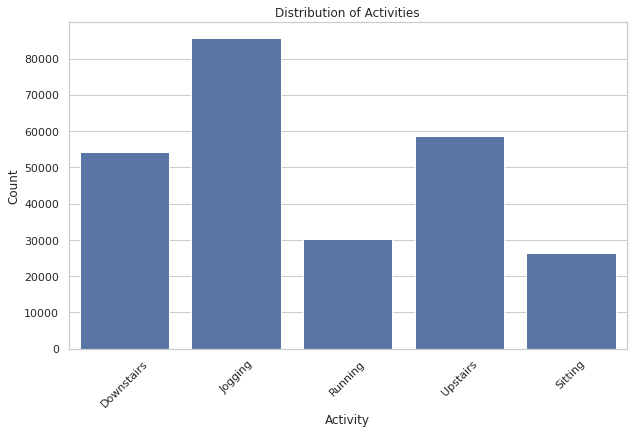

In [4]:
# 创建分布图
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Distribution of Activities')
plt.xticks(rotation=45)

# 显示图形
plt.show()

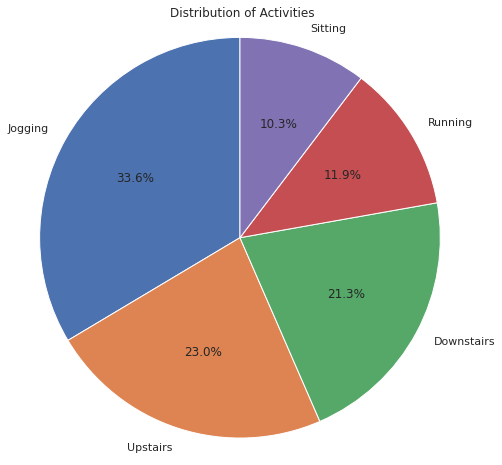

In [5]:
# 统计各个动作的数量
activity_counts = df_filtered['activity'].value_counts()

# 创建饼状图
plt.figure(figsize=(8, 8))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Activities')

# 显示图形
plt.axis('equal')
plt.show()

In [6]:
# selected_activities = ["Downstairs", "Upstairs","Running", "Jogging", "Standing"]
# df_filtered = df_filtered[df_filtered['activity'].isin(selected_activities)]
# df_filtered

In [7]:
# 划分数据集，基于用户ID
df_train = df_filtered[df_filtered['user-id'] < 6]
df_test = df_filtered[df_filtered['user-id'] >= 6]
df_test

,user-id,X,Y,Z,date,time,activity,activityEncode,X_filtered,Y_filtered,Z_filtered
276861,6,-7364.0,-26824.0,-7562.0,2023-10-29,14:51:30,Downstairs,0,2872.724847,-9963.358984,-23639.010034
276862,6,-6314.0,-24328.0,-6590.0,2023-10-29,14:51:30,Downstairs,0,1366.472899,-13416.036074,-22244.779188
276863,6,-3644.0,-18650.0,-5704.0,2023-10-29,14:51:30,Downstairs,0,472.732921,-15544.957354,-20807.144745
276864,6,-2528.0,-14514.0,-5662.0,2023-10-29,14:51:30,Downstairs,0,-135.007332,-16725.543245,-19487.412779
276865,6,-3758.0,-9872.0,-5128.0,2023-10-29,14:51:30,Downstairs,0,-903.182839,-16937.174390,-18191.043512
...,...,...,...,...,...,...,...,...,...,...,...
391091,7,2316.0,1534.0,18116.0,2023-10-30,13:11:45,Sitting,4,3867.806748,2521.540245,30337.252071
391092,7,2294.0,1572.0,18036.0,2023-10-30,13:11:45,Sitting,4,3866.639735,2534.289324,30332.305143
391093,7,2356.0,1540.0,18056.0,2023-10-30,13:11:45,Sitting,4,3876.748764,2540.209978,30331.368329
391094,7,2416.0,1446.0,18142.0,2023-10-30,13:11:45,Sitting,4,3896.866829,2528.562253,30346.101978


In [8]:
#数据训练前，先进行归一化，放到0-1范围
#将不同特征数值范围统一处理尺度
df_train.loc[:, 'X_filtered'] = (df_train['X_filtered'] - df_train['X_filtered'].min()) / (df_train['X_filtered'].max() - df_train['X_filtered'].min())
df_train.loc[:, 'Y_filtered'] = (df_train['Y_filtered'] - df_train['Y_filtered'].min()) / (df_train['Y_filtered'].max() - df_train['Y_filtered'].min())
df_train.loc[:, 'Z_filtered'] = (df_train['Z_filtered'] - df_train['Z_filtered'].min()) / (df_train['Z_filtered'].max() - df_train['Z_filtered'].min())
df_train



,user-id,X,Y,Z,date,time,activity,activityEncode,X_filtered,Y_filtered,Z_filtered
0,1,-728.0,11818.0,1134.0,2023-10-22,9:40:1,Downstairs,0,0.467606,0.622672,0.487549
1,1,-94.0,11166.0,618.0,2023-10-22,9:40:1,Downstairs,0,0.470880,0.638442,0.486052
2,1,306.0,10474.0,620.0,2023-10-22,9:40:1,Downstairs,0,0.474352,0.647053,0.485881
3,1,472.0,10116.0,384.0,2023-10-22,9:40:1,Downstairs,0,0.477173,0.653953,0.484947
4,1,874.0,13742.0,1182.0,2023-10-22,9:40:1,Downstairs,0,0.480829,0.672583,0.487731
...,...,...,...,...,...,...,...,...,...,...,...
272537,5,-12902.0,9634.0,1028.0,2023-10-28,16:31:10,Sitting,4,0.148004,0.681479,0.499455
272538,5,-12722.0,8630.0,1180.0,2023-10-28,16:31:10,Sitting,4,0.148591,0.680983,0.499678
272539,5,-12598.0,8708.0,1202.0,2023-10-28,16:31:10,Sitting,4,0.149468,0.680670,0.499961
272540,5,-13446.0,8324.0,1332.0,2023-10-28,16:31:10,Sitting,4,0.147939,0.679535,0.500591


In [9]:
#时间序列分割函数 按自定步度 步长进行分割 ，并返回分割后的时间序列和标签
#数据 时间序列分割的长度 步长 标签名
def segments(df, time_steps,step,label_name):
    N_FEATURES = 3   #s时间序列分割的特征长度 
    segments = []    #存储分割后的时间序列
    labels = []      #存储分割后的标签
    
    #0遍历索引，以步长递增 ，直到len(df) - time_steps
    #i 为当前位置，加上time_steps，表示分割结束的位置
    #xs ys zs 分别代表每个时间段内传感器数
    for i in range(0, len(df) - time_steps, step):
            xs = df['X_filtered'].values[i:i+time_steps]
            ys = df['Y_filtered'].values[i:i+time_steps]
            zs = df['Z_filtered'].values[i:i+time_steps]
            
            #计算label列众数
            label = mode(df[label_name][i:i+time_steps])  #这一段均为众数对应的活动
            segments.append([xs, ys, zs]) #分割后添加进去
            labels.append(label)
    #将sefmengts转换为NP数组，重塑 为三维数组      
    reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [10]:
#时间序列片段
#滑动窗口 80 定长  40重复 保证每次都有一般数据来源于上次数据区间
#预处理数据划分为一个个动作样本，滑动窗口用来划分动作种类
#一半的重复率 ：每个动作和下一个动作之间是时间间隔的，不是完全连续的

TIME_PERIOD = 128 
STEP_DISTANCE = 64
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
print(x_train.shape)
print(y_train)

# x_train 是返回的数据 y_train是返回的标签
# x_train ：样本数、时间段数、传感器数（每个时间步长包括3个传感器数据）
# 每个样本由一系列时间段组成，每个时间段由一系列传感器数据组成


# #时间段，传感器数和类的数量
# time_period,sensors = x_train.shape[1],x_train.shape[2]

# num_classes = label_encode.classes_.size  #获取标签列别的数量  为后续将标签转为独热编码做准备
# print(list(label_encode.classes_))        #类别列表转为列表


#将所有数据转换为float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# 标签转成独热编码
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
y_train_hot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

(2770, 128, 3)
[0 0 0 ... 4 4 4]


In [11]:
#数据训练前，先进行归一化，放到0-1范围
#将不同特征数值范围统一处理尺度
df_test.loc[:, 'X_filtered'] = (df_test['X_filtered'] - df_test['X_filtered'].min()) / (df_test['X_filtered'].max() - df_test['X_filtered'].min())
df_test.loc[:, 'Y_filtered'] = (df_test['Y_filtered'] - df_test['Y_filtered'].min()) / (df_test['Y_filtered'].max() - df_test['Y_filtered'].min())
df_test.loc[:, 'Z_filtered'] = (df_test['Z_filtered'] - df_test['Z_filtered'].min()) / (df_test['Z_filtered'].max() - df_test['Z_filtered'].min())
df_test

#相同的处理流程，处理测试集
x_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)
# #时间段，传感器数和类的数量
# time_period,sensors = x_test.shape[1],x_test.shape[2]
# num_classes = label_encode.classes_.size  #获取标签列别的数量
# print(list(label_encode.classes_))        #类别列表转为列表

#将所有数据转换为float32
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
print(x_test.shape)

# 标签转成独热编码
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
y_test_hot = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()


(1214, 128, 3)


In [12]:
from keras.layers import (Input, Conv1D, BatchNormalization, Activation, MaxPooling1D,
                          Bidirectional, GRU, Dropout, concatenate, Dense, GlobalAveragePooling1D, Attention)
from keras.models import Model
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def inception_module(x, kernel_sizes):
    towers = []
    for kernel_size in kernel_sizes:
        conv_layer = Conv1D(256, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
        activation_layer = Activation('relu')(conv_layer)
        towers.append(activation_layer)
    return concatenate(towers, axis=2)

def Multi_heads_InceptionCNN_BiGRU_Attention(input_size=(128, 3), num_classes=5):
    inputs = Input(shape=input_size)
    
    # Inception module
    inception_output = inception_module(inputs, [1, 3, 5])
    
    # First Bi-directional GRU
    gru_output_1 = Bidirectional(GRU(128, return_sequences=True))(inception_output)
    
    # Dropout after first BiGRU
    dropout_output_1 = Dropout(0.2)(gru_output_1)
    
    # Second Bi-directional GRU
    gru_output_2 = Bidirectional(GRU(64, return_sequences=True))(dropout_output_1)
    
    # Dropout after second BiGRU
    dropout_output_2 = Dropout(0.3)(gru_output_2)
    
    # Attention layer
    attention_output = Attention()([dropout_output_2, dropout_output_2])
    
    # Global Average Pooling
    gap_output = GlobalAveragePooling1D()(attention_output)
    
    # Dense layers
    fc1 = Dense(128, kernel_regularizer=l2(0.001))(gap_output)
    fc1 = Activation('relu')(fc1)
    fc2 = Dense(128, kernel_regularizer=l2(0.001))(fc1)
    fc2 = Activation('relu')(fc2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(fc2)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Instantiate the model
model = Multi_heads_InceptionCNN_BiGRU_Attention(input_size=(128, 3), num_classes=5)

# 定义训练过程中使用的参数
batch_size = 32
epochs = 150

# 编译模型，指定优化器、损失函数和评估指标
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(x_train, y_train_hot, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)  # 1 表示输出详细日志，2 表示输出精简日志

test_loss, test_accuracy = model.evaluate(x_test, y_test_hot, verbose=1)

# Calculate performance metrics
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_hot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
print(f"F1 Score: {f1:.4f}")

2024-08-19 10:33:41.042249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 10:33:41.469999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:03:00.0, compute capability: 8.9


Epoch 1/150


2024-08-19 10:33:45.410509: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 23204659200 bandwidth: 1008096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-08-19 10:33:46.192654: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-08-19 10:33:46.725767: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-19 10:33:46.725804: W tens

87/87 [==============================] - 8s 28ms/step - loss: 1.6326 - accuracy: 0.3552
Epoch 2/150
87/87 [==============================] - 2s 27ms/step - loss: 1.3411 - accuracy: 0.4502
Epoch 3/150
87/87 [==============================] - 2s 27ms/step - loss: 1.0902 - accuracy: 0.5357
Epoch 4/150
87/87 [==============================] - 2s 27ms/step - loss: 0.7841 - accuracy: 0.6433
Epoch 5/150
87/87 [==============================] - 2s 26ms/step - loss: 0.6297 - accuracy: 0.7184
Epoch 6/150
87/87 [==============================] - 2s 26ms/step - loss: 0.5506 - accuracy: 0.7661
Epoch 7/150
87/87 [==============================] - 2s 27ms/step - loss: 0.4746 - accuracy: 0.8025
Epoch 8/150
87/87 [==============================] - 2s 27ms/step - loss: 0.4366 - accuracy: 0.8310
Epoch 9/150
87/87 [==============================] - 2s 27ms/step - loss: 0.3869 - accuracy: 0.8462
Epoch 10/150
87/87 [==============================] - 2s 27ms/step - loss: 0.3720 - accuracy: 0.8588
Epoch 11/15

2024-08-19 10:39:44.583527: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 23204659200 bandwidth: 1008096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


 1/38 [..............................] - ETA: 28s

2024-08-19 10:39:46.031595: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 23204659200 bandwidth: 1008096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


38/38 [==============================] - 1s 14ms/step


NameError: name 'y_test_onehot' is not defined

In [13]:
# Calculate performance metrics
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_hot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
print(f"F1 Score: {f1:.4f}")

38/38 [==============================] - 0s 12ms/step
Confusion Matrix:
[[243   0   0   0   1]
 [  1 433   3   0   0]
 [  1   0 125   0   6]
 [  2   0   0 115   1]
 [ 22   0   0   0 261]]
Accuracy: 0.9695
Precision: 0.9700
Recall: 0.9661
F1 Score: 0.9674


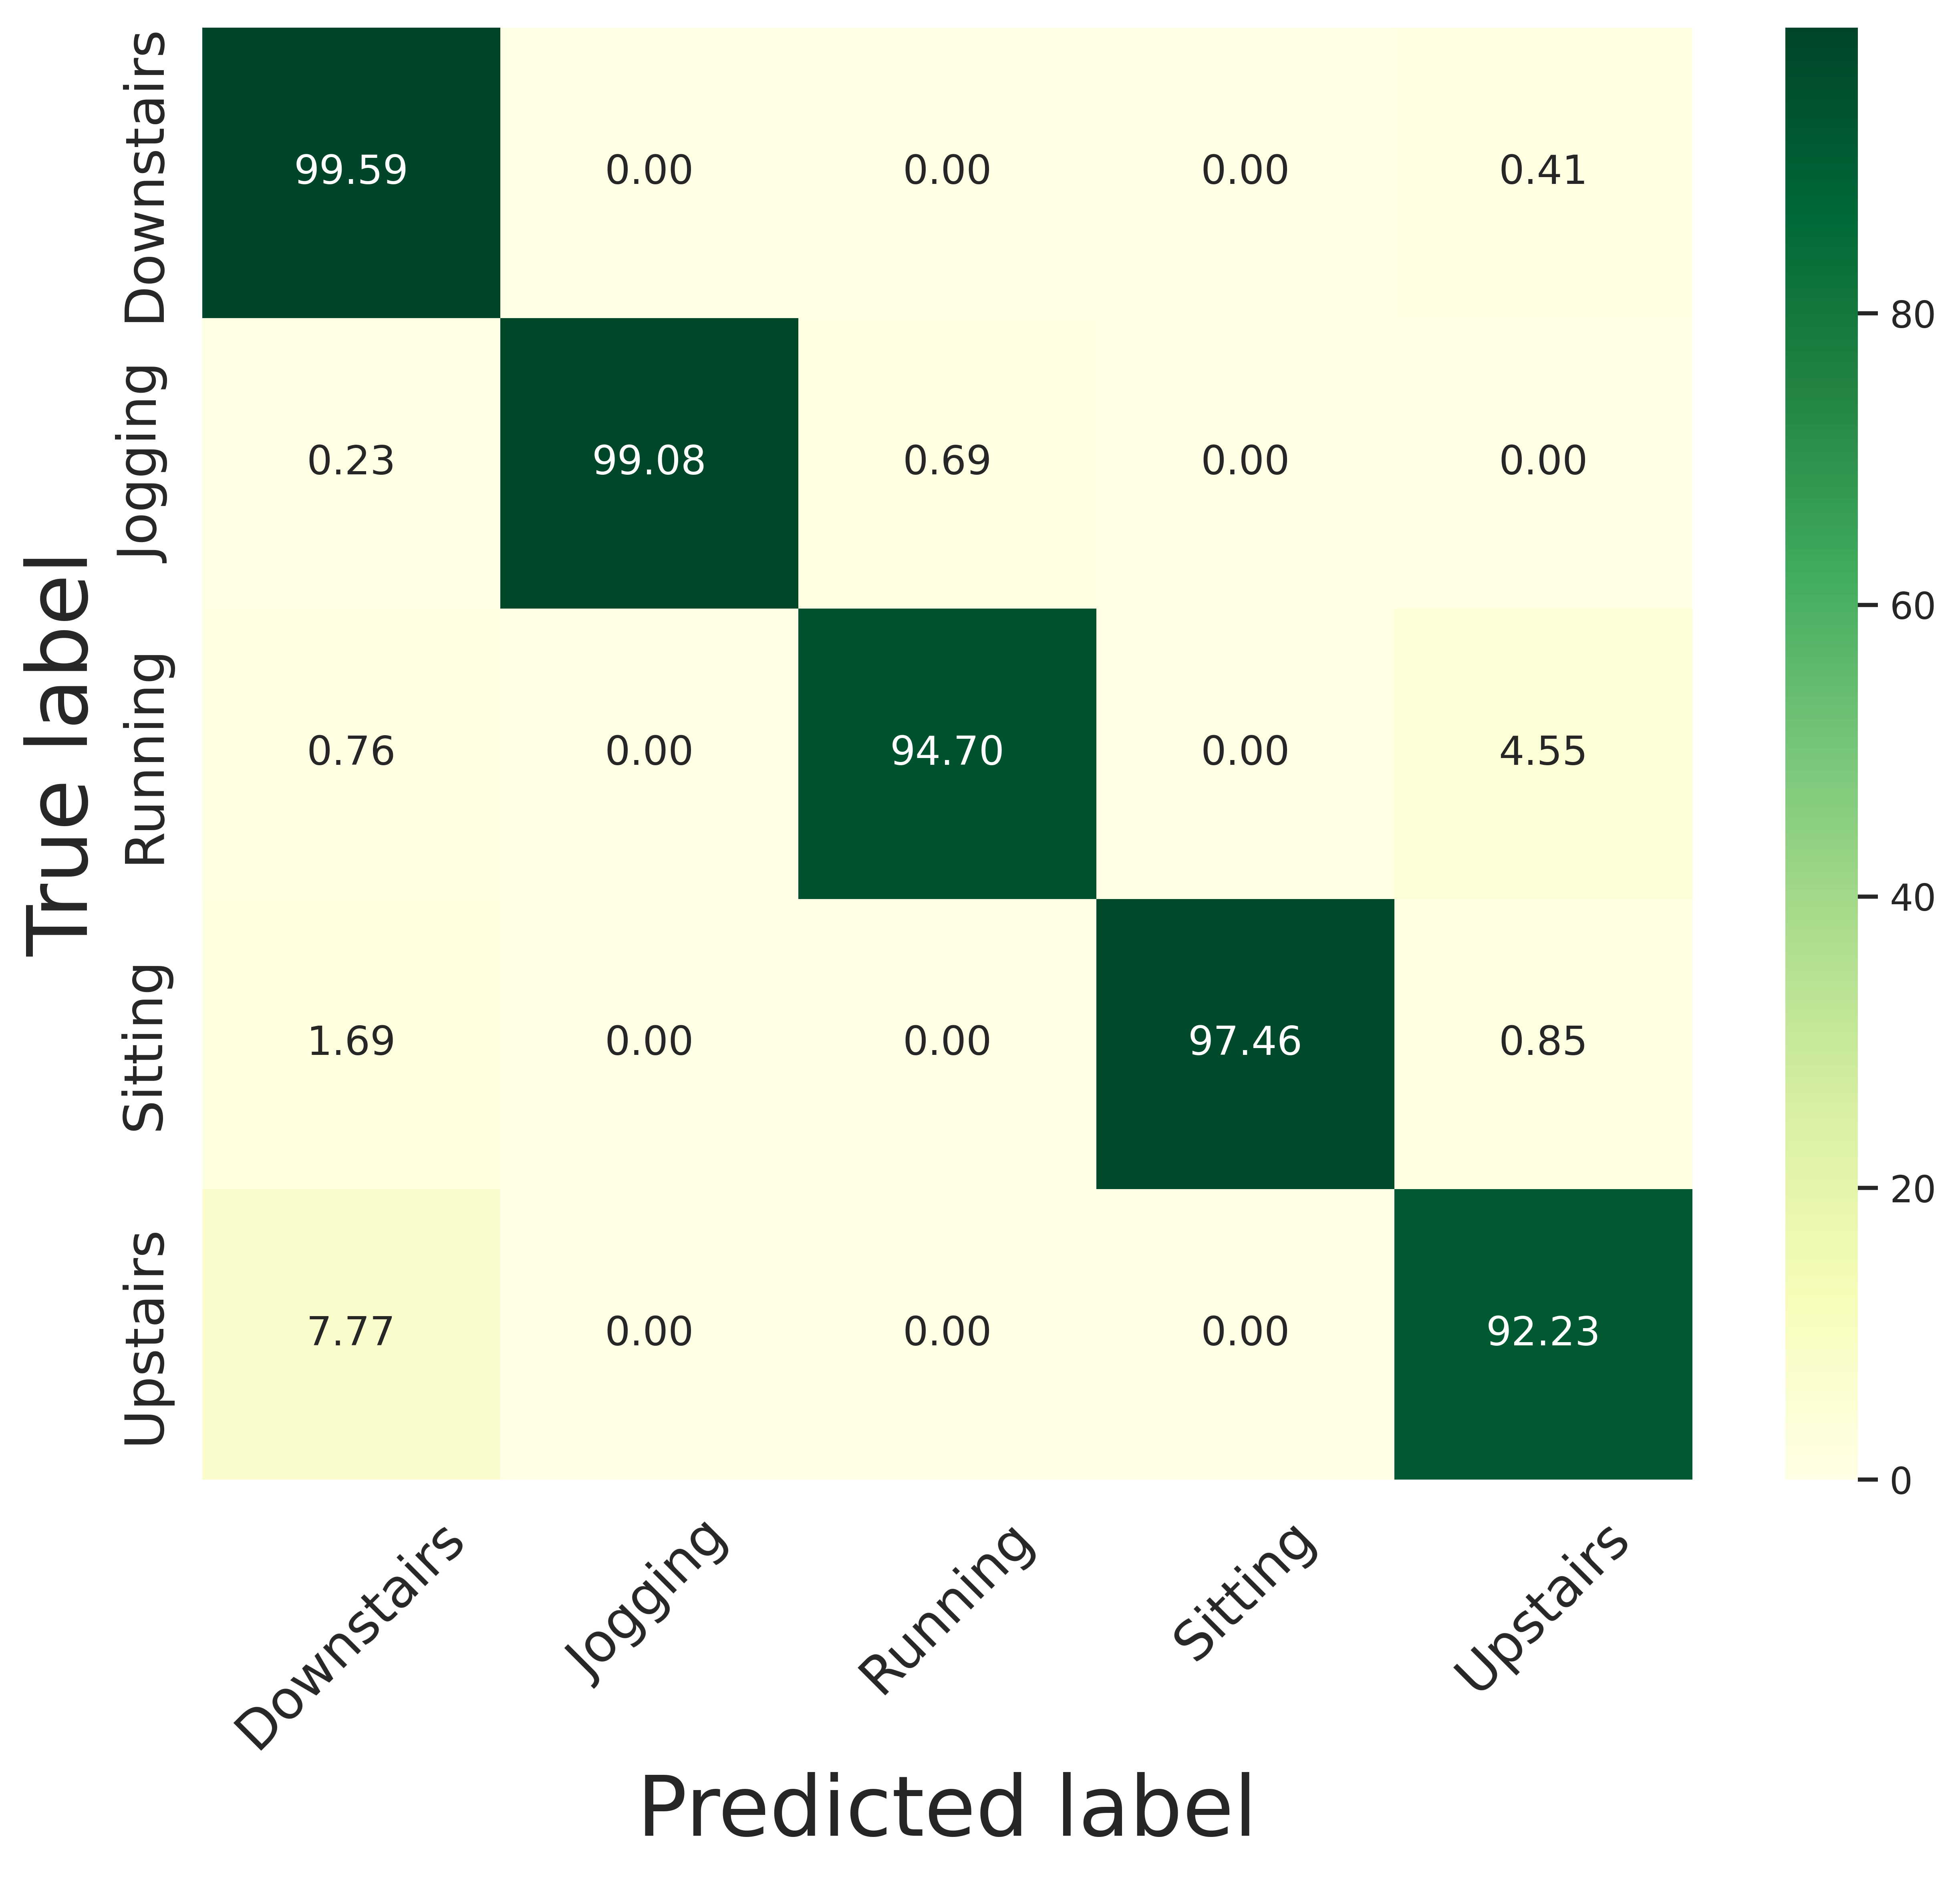

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already calculated the confusion matrix `cm` and the labels `labels`

# Calculate the total samples for each class
class_totals = cm.sum(axis=1)

# Convert the confusion matrix values to percentages
cm_percent = np.round((cm / class_totals[:, np.newaxis]) * 100, decimals=2)

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 8), dpi=600)
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="YlGn")

# Set the x-axis ticks and labels
plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=45, fontsize=16)
# Set the y-axis ticks and labels
plt.yticks(np.arange(len(labels)) + 0.5, labels, fontsize=16)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Predicted label', fontsize=25)
plt.show()